<a href="https://colab.research.google.com/github/jonasbarth/bdc-homework-2/blob/main/HW2_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

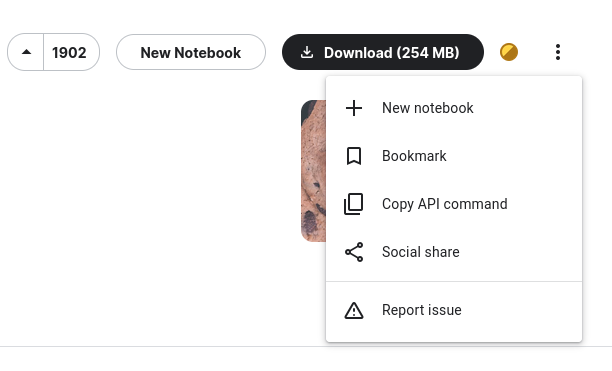

The copy-pasted command is the one shown below:

In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 99% 239M/242M [00:02<00:00, 214MB/s]
100% 242M/242M [00:02<00:00, 119MB/s]


In [4]:
!chmod 600 /content/kaggle.json

We next check that everything is there:

In [5]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [6]:
from zipfile import ZipFile
from pathlib import Path

In [7]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
    Path("./data").mkdir(exist_ok=True, parents=True)
   # Extract all the contents of zip file in current directory
    zipObj.extractall("./data")

Let's check what files are there (we are looking for ```Reviews.csv```)

In [8]:
!ls data

database.sqlite  hashes.txt  Reviews.csv


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [9]:
!head -10 data/Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

#### Load the Reviews file.
As a first step, we load the `Reviews.csv` file.

In [10]:
import pandas as pd
raw_pd = pd.read_csv("data/Reviews.csv", index_col=0)

In [11]:
raw_pd

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...
568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."


We write the **product ID** and **user ID** of the sampled rows to the provided `fout` file, with columns separated by comma `,`. We only save these two columns because for the co-review graph, we need to know which users reviewed which products.

In [12]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout

def sample_users(raw_pd, rate, buckets, fout):
    for index, row in raw_pd.iterrows():
        if (hash(row["UserId"])%buckets < rate):
            row_str = ",".join(map(str, [row["ProductId"], row["UserId"]]))
            fout.write(row_str)
            fout.write("\n")
            # Save this line to fout
            # You have to complete this part of the function's body


sampled_file = "data/Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w")
sample_users(raw_pd, rate, buckets, fout)
fout.close()

As a next step, we will install `pyspark` to make use of the massive parallel computing by Spark.

In [13]:
!pip install pyspark --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Co-Review Graph
In the following section, we will build the co-review graph. The co-review graph is a structure where **vertices** are Amazon users and **edges** between users mean that they have reviewed the same product. The **weight** of the connection signifies the number of the same products that both have reviewed.

The adjacency list of the co-review graph would look something like so:

```
user1 [(user2, 2), (user3, 1)...]
... ...
user2 [(user2, 2), (user1, 1)...]
```

### 1. Setup Spark
As a first step, we need to create a spark context and pass it the file with the **review graph**. The **review graph** is a graph where vertices are **users** and **products** with edges between the two if a user has reviewed a product. Below is an example of the **edges** in the graph.

```
user1 product10
user2 product2
...
user70 product 2
```

In [14]:
full_reviews_path = "data/full_reviews.csv"
full_reviews = raw_pd[["ProductId", "UserId"]].to_csv(full_reviews_path, index=None)

In [15]:
import pyspark
from pyspark import SparkContext, SparkConf
import operator

sc = SparkContext(appName="co-review-graph").getOrCreate()
file_in = "data/full_reviews.csv"
full_reviews = sc.textFile(file_in)

In [16]:
!ls data/

database.sqlite  full_reviews.csv  hashes.txt  Reviews.csv  Reviews_sampled.csv


### 2. Find Product Reviewers
Having created the spark context, we can perform the initial step of the graph building procedure. For each product, we want to find **all** users that have reviewed a product. This will later enable us to find the common reviewed products among users. Essentially, we just want to find the **neighbours** of each **product** node $p$. Let $E$ be the edge set of the graph, then the neighbours are connected nodes.

$$
N(p) = \{u ∣ (p,u) \in E\}
$$

I call the users that review a product, **product reviewers**. The `find_product_reviewers` function below maps each **product** to a list of **users** that have reviewed that product.

In [17]:
def find_product_reviewers(data: pyspark.RDD):
    """For a product-user graph, for each product finds the users that have reviewed that product.

    :arg
        data (pyspark.RDD): the user-product graph, which consists of <productID>, <userID> tuples on each line.

    :return
        (pyspark.RDD): each product ID, mapped to a list of user IDs that have reviewed it. <productID>, [<user1>, <user2>,...]
    """
    return data.map(lambda line: line.split(",")) \
                .map(lambda user_product: (user_product[0], [user_product[1]])) \
                .reduceByKey(operator.add)

In [18]:
product_reviewers = find_product_reviewers(full_reviews)

###3. Per-product user pairs
Now that we have a list of users that reviewed each product, we want to find all the possible **user pairs** per product. Basically, we are taking the **cartesian product** of all reviewers for each product, and then **flattening** the output to get an RDD with `<user> <user>` pairs.

Let $U_p$ be the set of users that reviewed the product $p$, which is just the neighbours $N(p)$ of the product $p$. Then, we create each possible user combination.

\begin{align}
    U_p &= N(p) \\
    U_p &\times U_p
\end{align}

The function `per_product_user_pairs` below computes this **cartesian product** between each product reviewers list and returns a flattened RDD, such that we have a user tuples like so:

```
user1 user2 #user 1 and user 2 have reviewed the same product
...
user550 user2 #user 550 and user 2 have also reviewed the same product
```

Note that we lose the product information at this point, but since it is not relevant to the task it does not matter. With this type of structure, we can easily count the number of times that users have reviewed the same product, since each line corresponds to a product that both users reviewed.

In [19]:
def per_product_user_pairs(product_reviewers: pyspark.RDD):
    """Finds the per-product user pairs for an product reviewers RDD and flattens them.

    :arg
        product_reviewers (pyspark.RDD): a pyspark RDD where product IDs are mapped to lists of users that have reviewed that product.

    :return
        (pyspark.RDD): a pyspark RDD where each element is (<user>, <user>) tuple.
    """
    return product_reviewers.map(lambda product_users: product_users[1]) \
                            .flatMap(lambda users: [(user1, user2) for user1 in users for user2 in users])

In [20]:
per_product_pairs = per_product_user_pairs(product_reviewers)

###4. Count users
We now have an RDD where each element is a user tuple `(<user>, <user>)` where both users share a **common reviewed product**. The final step to finding the **number** of common reviewed products, is to for each user, count the number of users it is connected to.

Since the RDD at this stage is essentially a **multigraph**, we just need to count the number of connections between user vertices to build the co-review graph. We can do this by:

1. mapping each user tuple to a $1$, `(<user>, <user>) -> ((<user>, <user>), 1)`, so that we can count the occurences later.
1. group on each user tuple `(<user>, <user>)` and sum up the values. Through this, we count the number of **edges** between the two users.
1. map each `((<user>, <user>), <count>)` to `(<user>, [(<user>, <count>)])`.
1. group by `<user>`and add the co-review lists for each user to each other. After this step we have mapped each **user** to a list of other users that they share reviews with as well as the **number of reviews** they share with each user.
1. sort the co-review lists by the `<count>` in descending order.

The function `count_users` below performs all of these steps and returns an RDD of the structure:

```
(<user>, [(<user>, <count>)])
...
(<user>, [(<user>, <count>)])
```

In [21]:
def count_users(user_pairs: pyspark.RDD, sort: bool, descending: bool):
    """Counts the number commonly reviewed products between users and maps each user to a list of (<user>, <common product review count>) tuples.

    :arg
        user_pairs (pyspark.RDD): pyspark RDD where each element is a user tuple (<user>, <user>).
        sort (bool): True if the list should be sorted by the <common product review count>, False if not.
        descending (bool): True if the list should be sorted in descending order, False if ascending.

    :return
        (pyspark.RDD): a pyspark RDD where each user is mapped to a list [(<user>, <common product review count>)...], sorted by the common product review count.
    """
    # map each user pair to a key-value pair, where key is (user1, user2) and value is 1
    user_pair_counts = user_pairs.map(lambda user_pair: ((user_pair[0], user_pair[1]), 1))

    # count the occurrences of each unique key, map users to lists, and add the lists
    user_pair_counts = user_pair_counts.reduceByKey(operator.add) \
                                .map(lambda users_counts: (users_counts[0][0], [(users_counts[0][1], users_counts[1])])) \
                                .reduceByKey(operator.add)

    if sort:
        user_pair_counts = user_pair_counts.mapValues(lambda user_counts: sorted(user_counts, key=lambda x: x[1], reverse=descending))

    return user_pair_counts

In [22]:
co_review_graph = count_users(per_product_pairs, sort=True, descending=True)

### 5. Save To File
As a final step, we save the finished co-review graph to a file. Collecting the data is not feasable due to the size, so we will first move it to a single partition using the `coalesce` function before saving it into a file.

In [30]:
co_review_graph.coalesce(1, shuffle=True).saveAsTextFile("data/single/")

We can check that the file was indeed saved.

In [31]:
!ls data/single/

part-00000  _SUCCESS


Having written the Co Review Graph RDD to the file, we can check the first 10 lines of the file.

In [32]:
!head -10 data/single/part-00000

('A34BFOXOM87TCY', [('A34BFOXOM87TCY', 12), ('APVK8GGSSUDCE', 4), ('A16WPA6JV83YXT', 4), ('A1ZH9LWMX5UCFJ', 3), ('A2OZ6PW2W5FQTP', 3), ('ACEA95FQS1AVP', 3), ('A141W8WHW9AC3H', 3), ('A5BJMAHZWGJ7N', 3), ('A1TR9417Z4U72F', 3), ('A1VBDMNT6I8RE5', 3), ('A3C2CPTCMB7S4N', 3), ('A1LJR5IS0B6ADX', 3), ('A2TXMYYGSZCSZ1', 3), ('A35JP8KSV9281K', 3), ('A1Q08H4B9QGT2N', 3), ('A27L5L6I7OSV5B', 3), ('ASJ0MKRFZC47B', 3), ('A3QVAKVRAH657N', 2), ('A350HRB16YUX9P', 2), ('A18GJ9MYYO6GCQ', 2), ('ANHL7BB84WJMF', 2), ('A2FJ5NWS5LQ9LN', 2), ('AL6CEWLV2JB90', 2), ('A3F68N9OI8Y67', 2), ('A1VF5LN6SHFVFJ', 2), ('A2KJZXIXBHVG0K', 2), ('A2FRAS05LEI6JJ', 2), ('APXQHFTTYERDE', 2), ('A3CG6YLYZJXQG4', 2), ('A2I05FGBTCRRB8', 2), ('A688RIZ2POWSQ', 2), ('A7T1NIWZHTC4P', 2), ('A3VBXQKRM7A4JR', 2), ('A1URMXEEWEQR6V', 2), ('A2ANDN3UQBKMCN', 2), ('A3W4D8XOGLWUN5', 2), ('A3EP6YVAYS9YM3', 2), ('A39D7ONPOORMUT', 2), ('A35HOUWHAYZZN6', 2), ('A2CF66KIQ3RKX3', 2), ('A3A15L96IYUO6V', 2), ('A2OW356OMJNAVH', 2), ('A4KJTS5P78ICU', 2), (